In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


In [4]:
# Load aligned bulk and single-cell (pseudo-bulked) embeddings
bulk_embeddings = pd.read_csv("embeddings/bulk_embeddings_aligned_to_sc.csv", index_col=0)
sc_embeddings = pd.read_csv("embeddings/pseudobulk_sc_embeddings_aligned.csv", index_col=0)

print(f"Bulk shape: {bulk_embeddings.shape}")
print(f"SC shape: {sc_embeddings.shape}")


Bulk shape: (140, 3072)
SC shape: (140, 3072)


In [5]:
NUM_PCS = 100

pca_bulk = PCA(n_components=NUM_PCS, random_state=42)
pca_sc = PCA(n_components=NUM_PCS, random_state=42)

bulk_pcs = pca_bulk.fit_transform(bulk_embeddings)
sc_pcs = pca_sc.fit_transform(sc_embeddings)


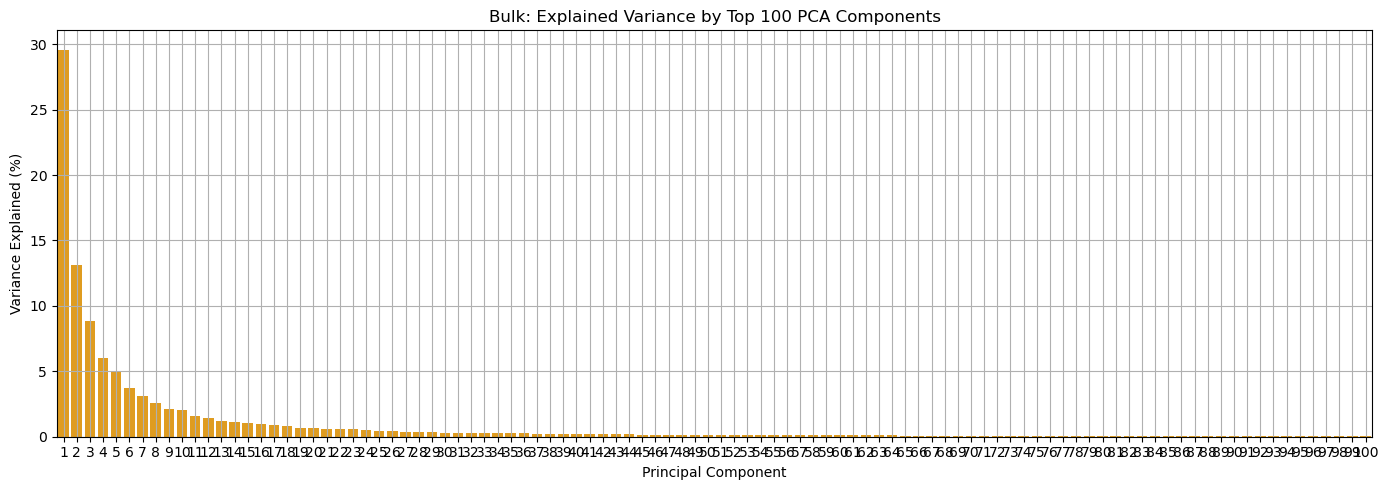

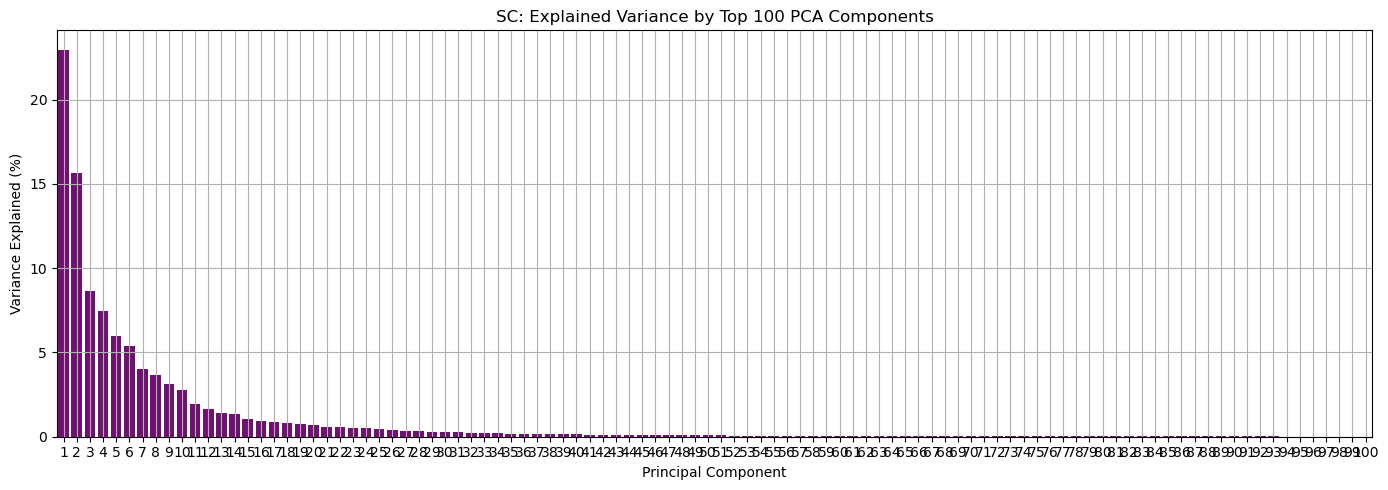

In [6]:
plt.figure(figsize=(14, 5))
sns.barplot(x=np.arange(1, NUM_PCS + 1), y=pca_bulk.explained_variance_ratio_ * 100, color="orange")
plt.title("Bulk: Explained Variance by Top 100 PCA Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
sns.barplot(x=np.arange(1, NUM_PCS + 1), y=pca_sc.explained_variance_ratio_ * 100, color="purple")
plt.title("SC: Explained Variance by Top 100 PCA Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


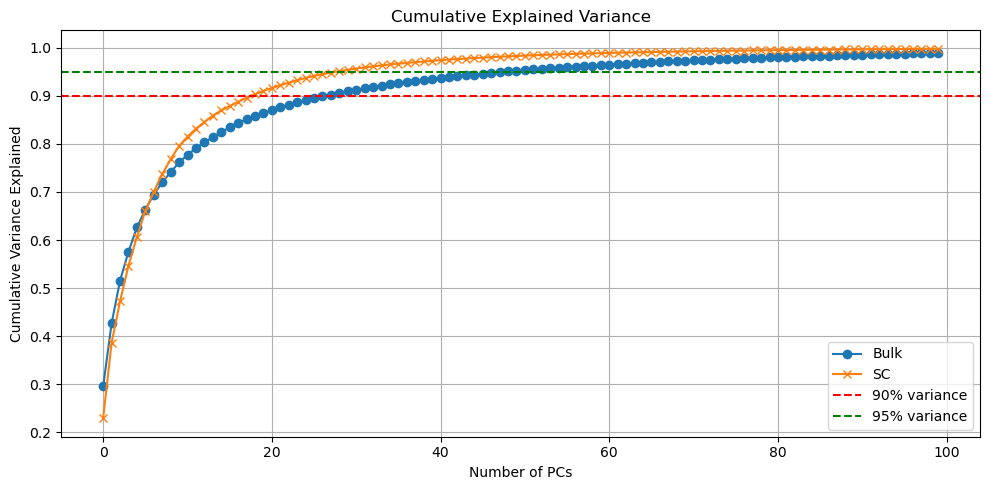

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_bulk.explained_variance_ratio_), label="Bulk", marker="o")
plt.plot(np.cumsum(pca_sc.explained_variance_ratio_), label="SC", marker="x")
plt.axhline(0.9, color="red", linestyle="--", label="90% variance")
plt.axhline(0.95, color="green", linestyle="--", label="95% variance")
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative Variance Explained")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
SELECTED_PCS = 30

# Re-load embeddings with IDs
bulk_ids = pd.read_csv("embeddings/bulk_embeddings_aligned_to_sc.csv")[["SANGER_MODEL_ID"]]

# For single-cell: if SANGER_MODEL_ID is the index, we reset it to use as a column
sc_ids = pd.read_csv("embeddings/pseudobulk_sc_embeddings_aligned.csv", index_col=0)
sc_ids = sc_ids.reset_index()[["SANGER_MODEL_ID"]]

# PCA DataFrames
bulk_df = pd.DataFrame(bulk_pcs[:, :SELECTED_PCS], columns=[f"PC{i+1}" for i in range(SELECTED_PCS)])
sc_df = pd.DataFrame(sc_pcs[:, :SELECTED_PCS], columns=[f"PC{i+1}" for i in range(SELECTED_PCS)])

# Merge IDs
bulk_df = pd.concat([bulk_ids.reset_index(drop=True), bulk_df], axis=1)
sc_df = pd.concat([sc_ids.reset_index(drop=True), sc_df], axis=1)

# Save
bulk_df.to_csv(f"data/training_data_bulk_pca{SELECTED_PCS}.csv", index=False)
sc_df.to_csv(f"data/training_data_sc_pca{SELECTED_PCS}.csv", index=False)

print("✅ PCA-transformed datasets saved with SANGER_MODEL_ID.")


✅ PCA-transformed datasets saved with SANGER_MODEL_ID.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (bulk or SC, same applies)
data = pd.read_csv("data/training_data_bulk.csv")  # or training_data_sc.csv

# Count unique SANGER_MODEL_IDs per DRUG_ID
drug_counts = data.groupby("DRUG_ID")["SANGER_MODEL_ID"].nunique().reset_index()
drug_counts = drug_counts.rename(columns={"SANGER_MODEL_ID": "n_cell_lines"})

# Sort and plot
plt.figure(figsize=(12, 5))
sns.histplot(drug_counts["n_cell_lines"], bins=30, kde=False, color="steelblue")
plt.axvline(200, linestyle="--", color="red", label="Min 200 (your threshold)")
plt.title("Number of Cell Lines per Drug")
plt.xlabel("Number of Unique Cell Lines")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optionally: print top and bottom
print("🔍 Drugs with the most tested cell lines:")
print(drug_counts.sort_values(by="n_cell_lines", ascending=False).head())

print("\n⚠️ Drugs with the fewest tested cell lines:")
print(drug_counts.sort_values(by="n_cell_lines").head())


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.